In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
fid = drive.ListFile({'q':"title='rice_leaf.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id': fid})
f.GetContentFile('rice_leaf.zip')
f.keys()
!unzip rice_leaf.zip

Archive:  rice_leaf.zip
replace paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1602.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1602.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1905.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_1988.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2019.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2094.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2316.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2441.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2659.jpg  
  inflating: paddyleafdiseaseuci (1) - Copy/test/Bacterial leaf blight/blight-_0_2829.jpg  
  inflating: paddyleaf

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import numpy as np
from tensorflow import keras

import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt
%matplotlib inline

print(tf.__version__)

2.12.0


In [ ]:
test_dataset = '/content/paddyleafdiseaseuci (1) - Copy/test'
train_dataset ="/content/paddyleafdiseaseuci (1) - Copy/train"
val_dataset ="/content/paddyleafdiseaseuci (1) - Copy/valid"

BATCH_SIZE = 20
IMG_SIZE = (224, 224)
no_classes = 3

In [ ]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 )
validation_dataset = tf.keras.utils.image_dataset_from_directory(val_dataset,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE,
                                                                 )
test_dataset = tf.keras.utils.image_dataset_from_directory(test_dataset,
                                                                 shuffle=True,
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 911 files belonging to 3 classes.
Found 219 files belonging to 3 classes.
Found 164 files belonging to 3 classes.


In [ ]:
class_names = train_dataset.class_names

(20, 224, 224, 3)
[0 1 2 2 1 0 1 2 1 1 0 0 1 2 0 2 2 2 1 2]


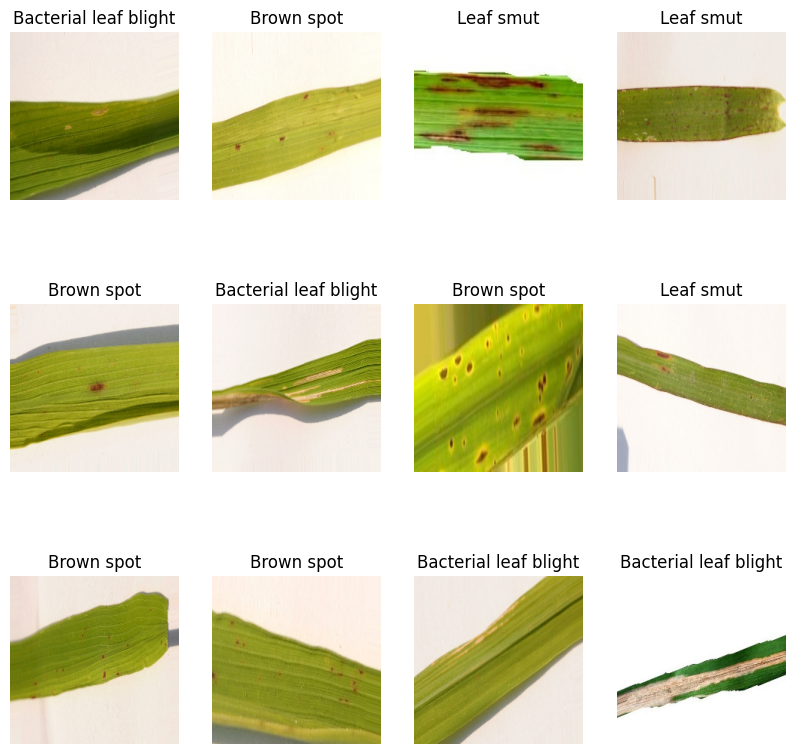

In [ ]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in train_dataset.take(1):
  print (image_batch.shape)
  print (labels_batch.numpy())
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy ().astype( "uint8" ) )
    plt.title(class_names[labels_batch[i]])
    plt.axis( "off" )

In [ ]:
#from tensorflow.keras import models, layers
#import matplotlib.pyplot as plt


#resize_and_rescale = tf.keras.Sequential([
#    layers.experimental.preprocessing.Rescaling(1.0/255),
#    layers.experimental.preprocessing.Resizing (256,256)
#]
#)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential ([

    layers.RandomTranslation(height_factor=0.1,width_factor=0.1),
    layers.RandomContrast(factor=0.2)
]
)


In [ ]:
base_model = keras.applications.VGG16(
    weights='imagenet',  # Load weights pre-trained on ImageNet.
    input_shape=(224, 224, 3),
    include_top=False)

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
nb_classes = 3
inputs = keras.Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # Apply random data augmentation
# Pre-trained Xception weights requires that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(x)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
x = keras.layers.Dense(512, activation="relu")(x)

outputs = Dense(nb_classes, activation="softmax")(x)
#outputs = keras.layers.Dense(13)(x)
model = keras.Model(inputs, outputs)

In [ ]:
model.compile(optimizer='adam' , loss='sparse_categorical_crossentropy',metrics =['accuracy'])

In [ ]:
epochs = 50
history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

Epoch 1/50
46/46 [==============================] - 15s 254ms/step - loss: 0.8465 - accuracy: 0.6169 - val_loss: 0.6986 - val_accuracy: 0.6712
Epoch 2/50
46/46 [==============================] - 11s 204ms/step - loss: 0.5326 - accuracy: 0.8013 - val_loss: 0.4033 - val_accuracy: 0.8858
Epoch 3/50
46/46 [==============================] - 9s 170ms/step - loss: 0.3904 - accuracy: 0.8683 - val_loss: 0.2859 - val_accuracy: 0.9087
Epoch 4/50
46/46 [==============================] - 10s 186ms/step - loss: 0.2990 - accuracy: 0.9078 - val_loss: 0.3304 - val_accuracy: 0.8904
Epoch 5/50
46/46 [==============================] - 10s 193ms/step - loss: 0.2501 - accuracy: 0.9166 - val_loss: 0.1969 - val_accuracy: 0.9361
Epoch 6/50
46/46 [==============================] - 10s 190ms/step - loss: 0.2260 - accuracy: 0.9254 - val_loss: 0.2108 - val_accuracy: 0.8995
Epoch 7/50
46/46 [==============================] - 9s 171ms/step - loss: 0.1811 - accuracy: 0.9407 - val_loss: 0.1952 - val_accuracy: 0.9224
E

In [ ]:
scores = model.evaluate(test_dataset)

9/9 [==============================] - 2s 95ms/step - loss: 0.1372 - accuracy: 0.9573


First image to predict
Actua1 Label:  Bacterial leaf blight
1/1 [==============================] - 0s 158ms/step
Predicted Label:  Bacterial leaf blight


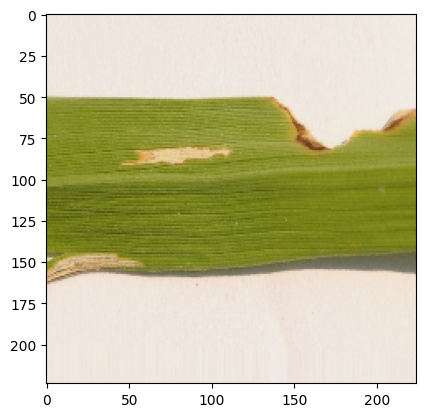

In [ ]:
for images_batch, labels_batch in test_dataset.take(1):
  first_image = images_batch[0].numpy().astype("uint8")

  print("First image to predict")
  plt.imshow (first_image)
  print("Actua1 Label: ",class_names[labels_batch[0].numpy()])

  batch_prediction = model.predict(image_batch)
  print("Predicted Label: " ,class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 22ms/step


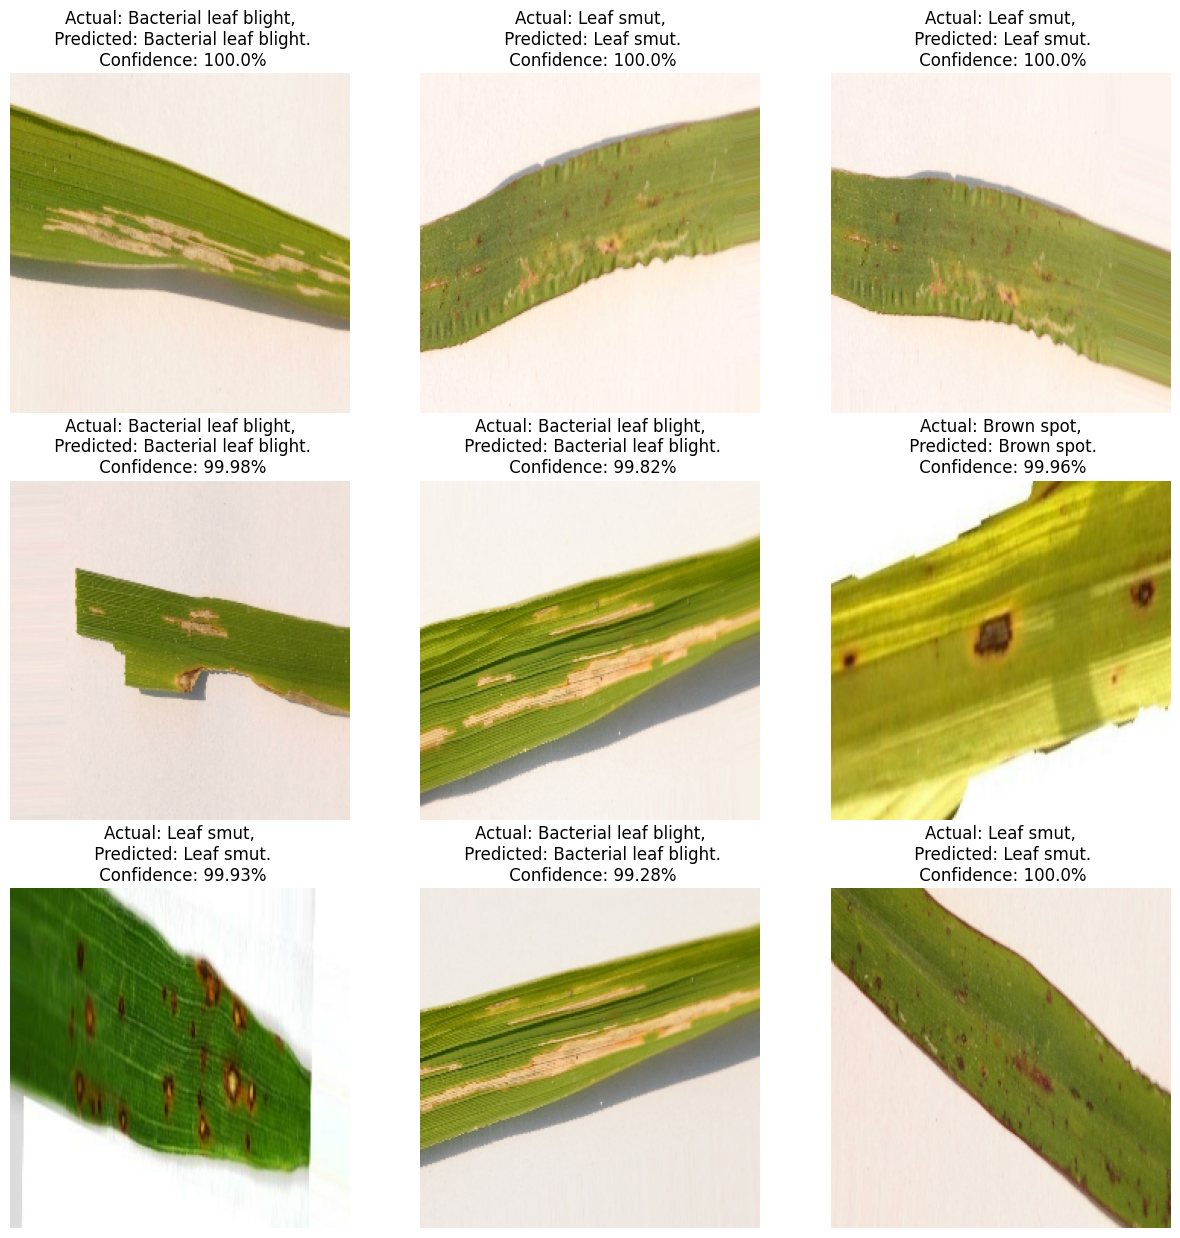

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

In [ ]:
image_to_predict = [
    "/content/cochliobolus.jpg",
    "/content/5390515.jpg",
    "/content/bbb.png"


    ]
for imgi in image_to_predict:
  img = keras.utils.load_img(imgi, target_size=(224,224))
  ix = keras.utils.img_to_array(img)
  ix = np.expand_dims(ix, axis=0)
  prediction = model.predict(ix)
  cls = tf.argmax(prediction[0], axis=-1)
  print(prediction, cls)
  print(f'{class_names[cls]} --> {imgi}')

1/1 [==============================] - 0s 20ms/step
[[6.5872075e-13 3.8418956e-02 9.6158105e-01]] tf.Tensor(2, shape=(), dtype=int64)
Leaf smut --> /content/cochliobolus.jpg
1/1 [==============================] - 0s 20ms/step
[[0.001338   0.00124535 0.9974166 ]] tf.Tensor(2, shape=(), dtype=int64)
Leaf smut --> /content/5390515.jpg
1/1 [==============================] - 0s 20ms/step
[[3.6860487e-01 4.4976975e-10 6.3139510e-01]] tf.Tensor(2, shape=(), dtype=int64)
Leaf smut --> /content/bbb.png
